# Constructing the magnetic diffusion

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sym
from pg_utils.pg_model import core, forcing
import matplotlib.pyplot as plt

Displaying utilities

In [2]:
def display_collection(collection, _filter=lambda item, idx: True):
    display(*(item for idx, item in enumerate(collection) if _filter(item, idx)))

# Linear drag model

In [3]:
display_collection(forcing.Dm_models_cg_lin["linear drag"])

None

-\overline{m_1}(s, \phi, t)

-\overline{m_+}(s, \phi, t)

-\overline{m_-}(s, \phi, t)

-\widetilde{m_{z+}}(s, \phi, t)

-\widetilde{m_{z-}}(s, \phi, t)

-\widetilde{zm_1}(s, \phi, t)

-\widetilde{zm_+}(s, \phi, t)

-\widetilde{zm_-}(s, \phi, t)

-b_{+}^e(s, \phi, t)

-b_{-}^e(s, \phi, t)

-b_{z}^e(s, \phi, t)

-b_{+, z}^e(s, \phi, t)

-b_{-, z}^e(s, \phi, t)

-b_{r1}(\theta, \phi, t)

-b_+^+(s, \phi, t)

-b_-^+(s, \phi, t)

-b_z^+(s, \phi, t)

-b_+^-(s, \phi, t)

-b_-^-(s, \phi, t)

-b_z^-(s, \phi, t)

In [19]:
import json
from pg_utils.pg_model import base
with open('./out/eigen/Toroidal_Quadrupole/eqs_cg.json', 'r') as fread:
    load_array = json.load(fread)
    eqs = base.LabeledCollection.deserialize(load_array['equations'], parser=sym.parse_expr)
    pars = [sym.parse_expr(par) for par in load_array["params"]]
with open('./out/eigen/Toroidal_Quadrupole/eqs_cg_drag.json', 'r') as fread:
    load_array = json.load(fread)
    eqs2 = base.LabeledCollection.deserialize(load_array['equations'], parser=sym.parse_expr)
    pars2 = [sym.parse_expr(par) for par in load_array["params"]]

for fname in eqs._field_names:
    if eqs[fname] is not None:
        print(
            fname, 
            eqs[fname].lhs.equals(eqs2[fname].lhs),
            eqs[fname].rhs.equals(eqs2[fname].rhs)
        )
        display(eqs2[fname].rhs - eqs[fname].rhs)

Psi True True


0

M_1 True False


-\overline{m_1}(s, \phi, t)/\mathrm{Lu}

M_p True False


-\overline{m_+}(s, \phi, t)/\mathrm{Lu}

M_m True False


-\overline{m_-}(s, \phi, t)/\mathrm{Lu}

M_zp True False


-\widetilde{m_{z+}}(s, \phi, t)/\mathrm{Lu}

M_zm True False


-\widetilde{m_{z-}}(s, \phi, t)/\mathrm{Lu}

zM_1 True False


-\widetilde{zm_1}(s, \phi, t)/\mathrm{Lu}

zM_p True False


-\widetilde{zm_+}(s, \phi, t)/\mathrm{Lu}

zM_m True False


-\widetilde{zm_-}(s, \phi, t)/\mathrm{Lu}

B_ep True False


-b_{+}^e(s, \phi, t)/\mathrm{Lu}

B_em True False


-b_{-}^e(s, \phi, t)/\mathrm{Lu}

Bz_e True False


-b_{z}^e(s, \phi, t)/\mathrm{Lu}

dB_dz_ep True False


-b_{+, z}^e(s, \phi, t)/\mathrm{Lu}

dB_dz_em True False


-b_{-, z}^e(s, \phi, t)/\mathrm{Lu}

Br_b True False


-b_{r1}(\theta, \phi, t)/\mathrm{Lu}

B_pp True False


-b_+^+(s, \phi, t)/\mathrm{Lu}

B_pm True False


-b_-^+(s, \phi, t)/\mathrm{Lu}

Bz_p True False


-b_z^+(s, \phi, t)/\mathrm{Lu}

B_mp True False


-b_+^-(s, \phi, t)/\mathrm{Lu}

B_mm True False


-b_-^-(s, \phi, t)/\mathrm{Lu}

Bz_m True False


-b_z^-(s, \phi, t)/\mathrm{Lu}

---
# Forms of diffusion term

## Temperature - a scalar

In [4]:
from pg_utils.pg_model import base_utils as mutils

T = sym.Function('T')(core.s, core.p, core.z)
T_bar = sym.Function(r'\overline{T}')(core.s, core.p)
D_T = sym.Function(r'd_T')(core.s, core.p)
D_T_tot = sym.Symbol(r'\mathcal{D}_T')

display(
    T, 
    sym.Eq(T_bar, mutils.integrate_sym(T)), 
    D_T,
    sym.Eq(D_T_tot, sym.integrate(core.s*D_T, (core.s, 0, 1)))
)

T(s, \phi, z)

Eq(\overline{T}(s, \phi), Integral(T(s, \phi, z), (z, -H(s), H(s))))

d_T(s, \phi)

Eq(\mathcal{D}_T, Integral(s*d_T(s, \phi), (s, 0, 1)))

Setup a field

In [5]:
T_sph = 2*core.r**2 - core.r**4
# T_sph = 3*core.r**2 - sym.Rational(5, 4)*core.r**6
T_expr = T_sph.subs({core.r**2: core.s**2 + core.z**2})
T_bar_expr = mutils.integrate_sym(T_expr)

display(
    sym.Eq(T, T_expr), 
    sym.Eq(T, T_sph), 
    sym.Eq(T_bar, T_bar_expr)
)

Eq(T(s, \phi, z), 2*s**2 + 2*z**2 - (s**2 + z**2)**2)

Eq(T(s, \phi, z), -r**4 + 2*r**2)

Eq(\overline{T}(s, \phi), 2*(2/3 - 2*s**2/3)*H(s)**3 + 2*(-s**4 + 2*s**2)*H(s) - 2*H(s)**5/5)

The quantity flux at the boundary

In [6]:
sym.Eq(sym.Derivative(T, core.r), sym.diff(T_sph, core.r).doit().subs({core.r: 1}), evaluate=False)

Eq(Derivative(T(s, \phi, z), r), 0)

In [7]:
sym.Eq(sym.Derivative(T_bar/core.H, core.s), sym.diff((T_bar_expr/core.H).simplify().subs({core.H: core.H_s}), core.s).subs({core.s: 1}), evaluate=False)

Eq(Derivative(\overline{T}(s, \phi)/H(s), s), 0)

### Maffei+ (2024) model

In the PG-II Manuscript (Maffei+ 2024), the following diffusion term for temperature is used:
$$
d_T = H \nabla_e^2 \left(\frac{\overline{T}}{H}\right)
$$

In [8]:
D_T_SM = core.H*core.cyl.div_h(core.cyl.grad_h(T_bar/core.H))
D_T_SM = D_T_SM.subs({core.H: core.H_s}).doit().subs({core.H_s: core.H}).expand()
# D_SM = D_SM.subs({sym.diff(core.H, core.s): -core.s/core.H}).doit().subs({sym.diff(core.H, core.s): -core.s/core.H}).doit().expand()
sym.Eq(D_T, D_T_SM)

Eq(d_T(s, \phi), 3*s**2*\overline{T}(s, \phi)/H(s)**4 + 2*s*Derivative(\overline{T}(s, \phi), s)/H(s)**2 + Derivative(\overline{T}(s, \phi), (s, 2)) + 2*\overline{T}(s, \phi)/H(s)**2 + Derivative(\overline{T}(s, \phi), s)/s + Derivative(\overline{T}(s, \phi), (\phi, 2))/s**2)

In [9]:
D_T_mod = D_T_SM
D_T_expr = D_T_mod.subs({T_bar: T_bar_expr})
D_T_expr = D_T_expr.subs({core.H: core.H_s}).doit().subs({core.H_s: core.H}).expand()

sym.Eq(D_T, D_T_expr)

Eq(d_T(s, \phi), -96*s**2*H(s)/5 - 32*H(s)**3/15 + 32*H(s)/3)

In [10]:
D_T_tot_expr = sym.integrate(core.s*D_T_expr.subs({core.H: core.H_s}), (core.s, 0, 1))

sym.Eq(D_T_tot, D_T_tot_expr)

Eq(\mathcal{D}_T, 128/225)

### Equatorial flux model

The following diffusion term gives the desired property that the diffusion term is only linked to the flux at the equator.  
Therefore, there will be no bulk energy change with a no-flux BC.
$$
d_T = \nabla_e \cdot \left(H \nabla_e \frac{\overline{T}}{H}\right)
$$

In [12]:
grad_tmp = core.cyl.grad_h(T_bar/core.H)
D_T_eqf = core.cyl.div_h((core.H*grad_tmp[0], core.H*grad_tmp[1]))
D_T_eqf = D_T_eqf.subs({core.H: core.H_s}).doit().subs({core.H_s: core.H}).expand()
sym.Eq(D_T, D_T_eqf)

Eq(d_T(s, \phi), 2*s**2*\overline{T}(s, \phi)/H(s)**4 + s*Derivative(\overline{T}(s, \phi), s)/H(s)**2 + Derivative(\overline{T}(s, \phi), (s, 2)) + 2*\overline{T}(s, \phi)/H(s)**2 + Derivative(\overline{T}(s, \phi), s)/s + Derivative(\overline{T}(s, \phi), (\phi, 2))/s**2)

In [13]:
D_T_mod = D_T_eqf
D_T_expr = D_T_mod.subs({T_bar: T_bar_expr})
D_T_expr = D_T_expr.subs({core.H: core.H_s}).doit().subs({core.H_s: core.H}).expand()

sym.Eq(D_T, D_T_expr)

Eq(d_T(s, \phi), 16*s**4/(3*H(s)) - 272*s**2*H(s)/15 - 16*s**2/(3*H(s)) - 32*H(s)**3/15 + 32*H(s)/3)

In [14]:
D_T_tot_expr = sym.integrate(core.s*D_T_expr.subs({core.H: core.H_s}), (core.s, 0, 1))

sym.Eq(D_T_tot, D_T_tot_expr)

Eq(\mathcal{D}_T, 0)

## Viscous diffusion in SWE

### Maffei+ (2024) model

In the PG-II Manuscript (Maffei+ 2024), the following diffusion term for temperature is used:
$$
d_T = H \nabla_e^2 \left(\frac{\overline{T}}{H}\right)
$$

In [127]:
from pg_utils.pg_model import base_utils as mutils

# u_p = core.s*(1 - core.s**2)
# u_p = core.s*(1 - 2*core.s**2 + core.s**4)
# u_p = 3*core.s - core.s**3
# u_p = sym.sin(core.s/10) - sym.sin(1/10)*core.s
k = sym.S.Pi*6
u_p = core.s + (-1/k/sym.cos(k))*sym.sin(k*core.s)
# u_p = core.s
# grad_u_norm = 10*core.s**4 - 8*core.s**2 + 2

grad_u_norm = sym.diff(u_p, core.s)**2 + (u_p/core.s)**2
grad_KE = sym.diff(u_p**2, core.s)/2

display(
    u_p.subs({core.s: 1}).evalf(),
    sym.diff(u_p, core.s).subs({core.s: 1}).evalf(),
    grad_u_norm,
    grad_KE
)

1.00000000000000

0

(1 - cos(6*pi*s))**2 + (s - sin(6*pi*s)/(6*pi))**2/s**2

(2 - 2*cos(6*pi*s))*(s - sin(6*pi*s)/(6*pi))/2

In [135]:
u_p

s - sin(6*pi*s)/(6*pi)

<lambdifygenerated-83>:2: RuntimeWarning: invalid value encountered in divide
  return (1 - cos(6*pi*s))**2 + (s - 1/6*sin(6*pi*s)/pi)**2/s**2


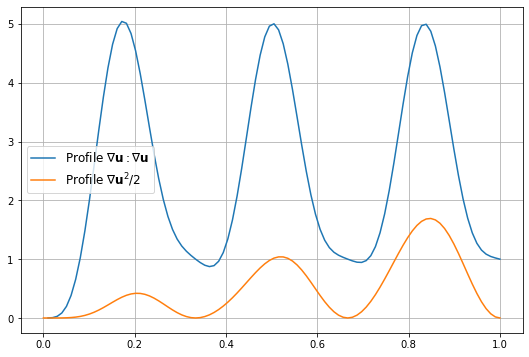

In [128]:
fig, ax = plt.subplots(figsize=(9, 6))

s_array = np.linspace(0., 1., num=100)

f_plot = sym.lambdify((core.s,), grad_u_norm, modules=['numpy', 'scipy'])
ax.plot(s_array, f_plot(s_array)*np.ones(s_array.shape), label=r'Profile $\nabla \mathbf{u} : \nabla \mathbf{u}$')

f_plot = sym.lambdify((core.s,), grad_KE, modules=['numpy', 'scipy'])
ax.plot(s_array, f_plot(s_array)*np.ones(s_array.shape), label=r'Profile $\nabla \mathbf{u}^2/2$')

ax.grid(which='both')
ax.legend(fontsize=12)
plt.show()

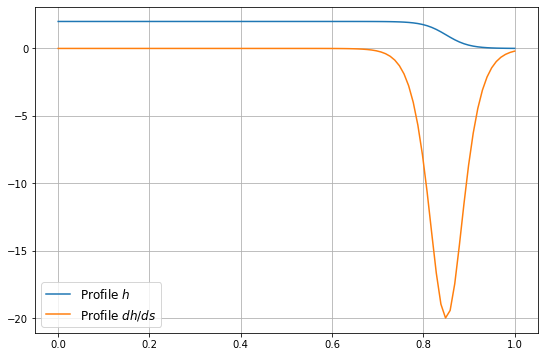

In [136]:
fig, ax = plt.subplots(figsize=(9, 6))

s_array = np.linspace(0., 1., num=100)
h_expr = 1 - sym.tanh(20*(core.s - 0.85))

f_plot = sym.lambdify((core.s,), h_expr, modules=['numpy', 'scipy'])
ax.plot(s_array, f_plot(s_array)*np.ones(s_array.shape), label=r'Profile $h$')

f_plot = sym.lambdify((core.s,), sym.diff(h_expr, core.s), modules=['numpy', 'scipy'])
ax.plot(s_array, f_plot(s_array)*np.ones(s_array.shape), label=r'Profile $dh/ds$')

ax.grid(which='both')
ax.legend(fontsize=12)
plt.show()

Setup thickness profile

In [137]:
from scipy.special import roots_legendre

# h_expr = 1 + 1*sym.sin(2*sym.S.Pi*core.s)
# h_expr = sym.S.One
h_expr = 1 - 1*sym.tanh(20*(core.s - 0.85))

def nintegrate(integrand_expr, var, N=100):
    f_lambda = sym.lambdify((var,), integrand_expr, modules=['numpy', 'scipy'])
    xi, wt = roots_legendre(N)
    f_eval = f_lambda((1 + xi)/2)
    return 1/2*(wt @ f_eval)

# boundary = (h_expr*u_p*sym.diff(u_p, core.s)).subs({core.s: 1})
# heating_loss = -sym.integrate(h_expr*grad_u_norm*core.s, (core.s, 0, 1))
# oppo_loss = -sym.integrate(sym.diff(h_expr, core.s)*grad_KE*core.s, (core.s, 0, 1))

# display(
#     boundary.evalf(),
#     heating_loss.evalf(),
#     oppo_loss.evalf()
# )

boundary = float((h_expr*u_p*sym.diff(u_p, core.s)).subs({core.s: 1}).evalf())
heating_loss = - nintegrate(h_expr*grad_u_norm*core.s, core.s)
oppo_loss = - nintegrate(sym.diff(h_expr, core.s)*grad_KE*core.s, core.s)

display(
    boundary,
    heating_loss,
    oppo_loss
)

0.0

-1.870994524382691

2.430514423149528